In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader, Sampler
from AdaIN import AdaIN

In [2]:
mn = mobilenet_v2(weights = MobileNet_V2_Weights.DEFAULT)
print(mn)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
style_path = "style/sketch.png"
image_path = "content/avril.jpg"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.ToTensor()
])

#coco content
train_content_dataset = datasets.ImageFolder(
    root= "../coco",             
    transform=transform
)

#wikiart
train_style_dataset = datasets.ImageFolder(
    root= "../archive",             
    transform=transform
)

train_content_loader = DataLoader(train_content_dataset, batch_size=1, shuffle=True)
train_style_loader = DataLoader(train_style_dataset, batch_size=1, shuffle=True)

In [4]:
encoder = nn.Sequential(*list(mn.features.children())[:18])
print(encoder)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

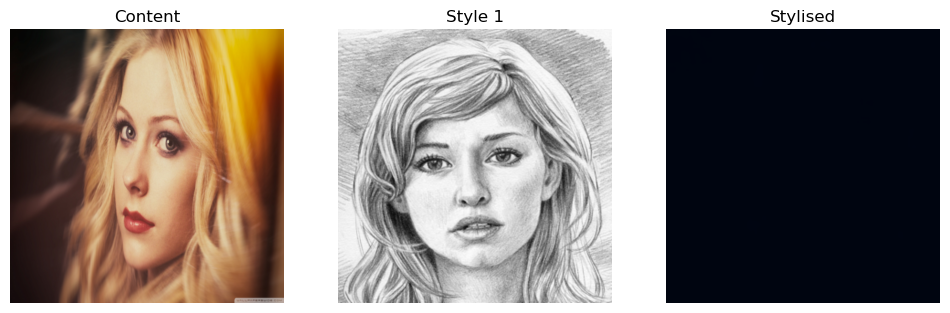

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.937, '245.633 ms')

In [5]:
decoder = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(320, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),)

mnModel = AdaIN(prebuild_decoder = "mobilenet_5.pth")
mnModel.uploadEncoder(encoder)
mnModel.uploadDecoder(decoder)
#training complete
# mnModel.epochTraining(train_content_loader, train_style_loader, "mobilenet", steps = 20000, epoch = 5)
mnModel.fit(image_path,[style_path])
mnModel.pipeline()
mnModel.displayImages()
mnModel.evaluate()

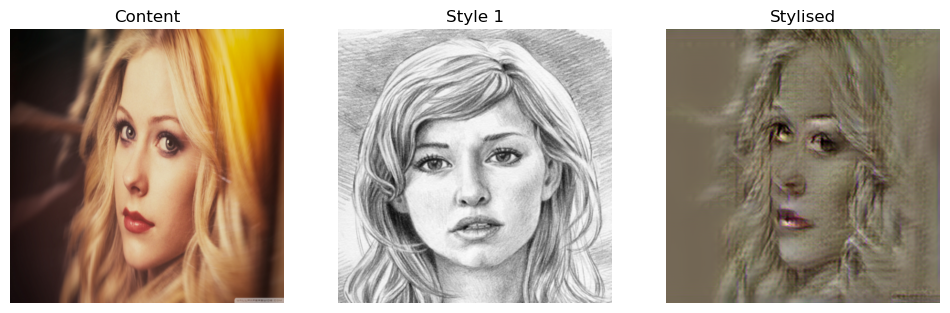

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.675, '70.505 ms')

In [6]:
encoder_new = nn.Sequential(*list(mn.features.children())[:10])
# print(encoder_new)

decoder_new = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),)

mnModel2 = AdaIN(prebuild_decoder = "mobilenet_layer9_5.pth")
mnModel2.uploadEncoder(encoder_new)
mnModel2.uploadDecoder(decoder_new)
#Training complete
# mnModel2.epochTraining(train_content_loader, train_style_loader, "mobilenet_layer9", steps = 20000, epoch = 5)
mnModel2.setup()
mnModel2.fit(image_path,[style_path])
mnModel2.pipeline()
mnModel2.displayImages()
mnModel2.evaluate()

Epoch: 1
[1000/20000] content=7.3974 style=1.4930 total=8.890345
[2000/20000] content=7.1354 style=1.3947 total=8.530139
[3000/20000] content=6.9603 style=1.3246 total=8.284953
[4000/20000] content=7.0218 style=1.3577 total=8.379433
[5000/20000] content=6.9737 style=1.3349 total=8.308606
[6000/20000] content=6.9368 style=1.2827 total=8.219553
[7000/20000] content=6.8739 style=1.2934 total=8.167294
[8000/20000] content=6.8083 style=1.2602 total=8.068524
[9000/20000] content=6.7597 style=1.2338 total=7.993576
[10000/20000] content=6.7322 style=1.2391 total=7.971343
[11000/20000] content=6.6911 style=1.2018 total=7.892915
[12000/20000] content=6.7727 style=1.2294 total=8.002113
[13000/20000] content=6.7190 style=1.2233 total=7.942317
[14000/20000] content=6.7184 style=1.2209 total=7.939288
[15000/20000] content=6.7524 style=1.2247 total=7.977023
[16000/20000] content=6.7923 style=1.2270 total=8.019244
[17000/20000] content=6.7207 style=1.1871 total=7.907802
[18000/20000] content=6.5967 st

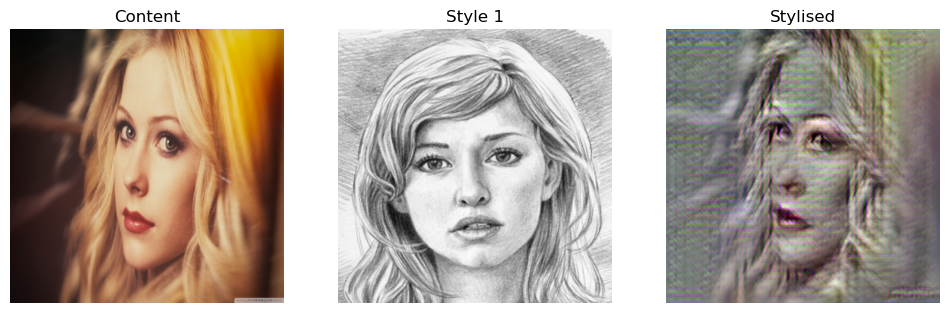

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.797, '60.184 ms')

In [7]:
encoder_l7 = nn.Sequential(*list(mn.features.children())[:8])

mnModel3 = AdaIN()
mnModel3.uploadEncoder(encoder_l7)
mnModel3.uploadDecoder(decoder_new)
#Training complete
mnModel3.epochTraining(train_content_loader, train_style_loader, "mobilenet_layer7", steps = 20000, epoch = 5)

mnModel3.fit(image_path,[style_path])
mnModel3.pipeline()
mnModel3.displayImages()
mnModel3.evaluate()